In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

Importación de datos de Lending Club para los años 2012-14

In [2]:
df2012_13 = pd.read_csv('./LoanStats_2012_to_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv('./LoanStats_2014.csv',low_memory=False,skiprows=1)

Limpieza de datos:

- Conjuntos de datos fusionados de 2012-14
- Eliminamos todas las columnas vacías (estas son las columnas con datos personales de los prestatarios. Estas no son divulgadas por la empresa, por lo que las eliminamos)
- Variable de destino (el prestatario es un moroso del préstamo): codificada en 0 o 1

In [3]:
dataset = pd.concat([df2012_13, df2014]) #fusionando conjuntos de datos de 2012 a 2014
dataset = dataset.iloc[:,2:111]          #eliminar columnas vacías
empty_cols = [i for i in range(45,72)]   #más columnas vacías
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #convertir la variable de destino a booleana
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [4]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (398460, 82)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,11500.0,11500.0,11500.0,60 months,22.90%,323.54,E,E4,Secretary,4 years,RENT,32760.0,Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > This loan is fo...,debt_consolidation,Debt Killer,937xx,CA,27.06,0.0,Mar-1999,0.0,NaN,NaN,12.0,0.0,9996.0,70.9%,17.0,f,0.0,0.0,18786.250257,...,9.0,2060.0,2689.0,70.1,0.0,0.0,34.0,177.0,14.0,1.0,0.0,20.0,NaN,14.0,NaN,0.0,5.0,8.0,6.0,7.0,4.0,10.0,13.0,8.0,12.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,30891.0,24724.0,9000.0,16791.0
1,28000.0,28000.0,28000.0,36 months,7.62%,872.52,A,A3,Area Sales Manager,5 years,MORTGAGE,325000.0,Source Verified,Dec-2013,0,n,NaN,NaN,debt_consolidation,Pay off other Installment loan,945xx,CA,18.55,0.0,Nov-1994,1.0,NaN,NaN,15.0,0.0,29581.0,54.6%,31.0,w,0.0,0.0,29150.980000,...,6.0,53306.0,13901.0,67.1,0.0,0.0,125.0,229.0,5.0,2.0,5.0,5.0,NaN,3.0,NaN,0.0,4.0,5.0,6.0,8.0,11.0,9.0,15.0,5.0,15.0,0.0,0.0,0.0,5.0,100.0,16.7,0.0,0.0,850886.0,199739.0,42200.0,196686.0
2,12000.0,12000.0,12000.0,36 months,13.53%,407.40,B,B5,On road manager,10+ years,RENT,40000.0,Source Verified,Dec-2013,0,n,NaN,NaN,debt_consolidation,Debt consolidation,871xx,NM,16.94,0.0,Oct-1998,0.0,53.0,33.0,7.0,2.0,5572.0,68.8%,32.0,w,0.0,0.0,13359.776858,...,4.0,2268.0,1428.0,79.6,0.0,0.0,124.0,182.0,1.0,1.0,0.0,11.0,53.0,17.0,53.0,6.0,2.0,2.0,3.0,14.0,8.0,6.0,24.0,2.0,7.0,0.0,0.0,0.0,2.0,81.2,33.3,0.0,0.0,18130.0,13605.0,7000.0,10030.0


In [5]:
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 es el número mínimo de valores no NA
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (398460, 76)


In [6]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #eliminando algunas columnas más
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (398460, 54)


In [7]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #'sub_grade' #seleccionando características finales #'addr_state''tax_liens',
Final_data = dataset[features] #19 características con var objetivo
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #quitando % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (398460, 18)


#Transformación de datos

Calificación: calificación otorgada por el prestatario basándose en su historial anterior, codificada en valores numéricos.

home_ownership : esta es una característica del conjunto de datos que tuvo que codificarse en valores numéricos.

Emp_Length: esta función no se formateó correctamente. Tiene algunos valores que estaban en el formato como "10 + años", "5 años" ... etc. los cambiamos a valores numéricos en la celda siguiente

In [8]:
#Codificación de datos
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:pd.to_numeric(x, downcast='integer'))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()#Codificación de datos


Current shape of dataset : (398460, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,11500.0,4.0,32760.0,5,3,4874.03,0.0,0.0,22.90,12.0,8.0,14.0,177.0,70.1,2689.0,2060.0,9.0,0
1,28000.0,5.0,325000.0,6,7,23915.86,5.0,0.0,7.62,15.0,5.0,5.0,229.0,67.1,13901.0,53306.0,6.0,0
2,12000.0,10.0,40000.0,5,6,119.17,0.0,2.0,13.53,7.0,2.0,1.0,182.0,79.6,1428.0,2268.0,4.0,0
3,15000.0,2.0,63000.0,6,7,476.23,4.0,0.0,8.90,8.0,4.0,24.0,189.0,79.1,2969.0,38927.0,3.0,0
4,24000.0,10.0,100000.0,6,6,10726.61,3.0,0.0,13.53,14.0,5.0,18.0,299.0,77.6,4822.0,15372.0,7.0,0


In [9]:
x=Final_data["emp_length"]

x[60]

4.0

In [10]:
Final_data.shape
Final_data.isnull().values.any()

True

#Relleno de valores perdidos y escala de funciones

Tenemos algunas características importantes a las que les faltan algunos valores. Completamos los valores que faltan con la media de la columna.

Escalamos las características de todas las características aquí usando un escalador estándar.

Tomamos muestras de nuestro conjunto de datos aquí después de inferir de la curva de aprendizaje trazada.

In [11]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (398460, 18)


In [12]:
Final_data.isnull().values.any()

False

In [13]:
scl = preprocessing.StandardScaler() #instancia de preprocesamiento
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    329108
1     69352
Name: loan_status, dtype: int64

In [14]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (11000, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,0.767044,0.837104,0.421701,0.895380,-3.242155,-0.636924,3.798420e+00,1.563513,2.726172,-0.266314,-0.928707,-0.607138,-2.797660e-01,1.259450e+00,-6.337049e-01,1.413574e+00,-0.079592,1
1,-1.320439,-1.510863,1.053250,0.895380,-2.473199,-0.714547,5.489283e-01,-0.323586,2.541289,-0.266314,-0.586615,-0.672154,-7.132300e-01,1.163423e+00,-6.021773e-01,1.090249e+00,-0.079592,1
2,1.316222,1.130600,-0.246998,-0.636019,-2.473199,-0.619374,-8.437110e-01,-0.323586,2.313039,-1.070070,-0.586615,0.563148,-5.535327e-01,1.194152e+00,-6.211395e-01,-5.095103e-01,-0.802034,1
3,-1.205142,-0.336879,-1.064297,-0.636019,-0.935286,-0.343200,-8.437110e-01,1.563513,1.338409,-1.271009,-0.244523,0.173053,2.822151e-02,-5.958015e-01,-2.864437e-01,-7.710056e-01,-1.163255,0
4,-0.719681,0.250112,0.533151,0.895380,-0.166329,-0.688244,1.030760e-16,-0.323586,-0.083592,-0.467253,0.000000,0.000000,3.242049e-16,-7.369020e-14,1.385229e-16,-2.333369e-16,0.000000,0


A continuación se muestran los valores de correlación entre las características finalmente seleccionadas.

In [15]:
data_clean.corr()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
funded_amnt,1.000000,0.106254,0.450101,0.178177,-0.179924,0.324022,0.231681,-0.080118,0.175721,0.197412,0.137593,0.054405,0.164639,0.050284,0.179782,0.243655,0.007860,0.083691
emp_length,0.106254,1.000000,0.077229,0.130638,-0.020929,0.054072,0.179170,0.028271,0.025058,0.024798,0.121804,0.013901,0.178928,0.042922,0.017632,0.089814,0.010188,-0.026976
annual_inc,0.450101,0.077229,1.000000,0.188282,0.041809,0.206267,0.288651,0.007523,-0.047024,0.180218,0.078144,0.061883,0.162025,-0.012325,0.196450,0.408106,0.042806,-0.079583
home_ownership,0.178177,0.130638,0.188282,1.000000,0.063739,0.090803,0.406276,0.001011,-0.061067,0.099965,0.038461,0.016447,0.094827,0.016254,0.057887,0.367204,0.041000,-0.043535
grade,-0.179924,-0.020929,0.041809,0.063739,1.000000,0.011326,0.055408,-0.050237,-0.961289,-0.024449,-0.103101,0.100121,0.092398,-0.272497,0.275581,0.090588,-0.161424,-0.296591
last_pymnt_amnt,0.324022,0.054072,0.206267,0.090803,0.011326,1.000000,0.129770,-0.042564,-0.011122,0.042872,-0.016482,0.043616,0.058159,-0.037408,0.110315,0.155137,-0.001222,-0.472075
mort_acc,0.231681,0.179170,0.288651,0.406276,0.055408,0.129770,1.000000,0.021555,-0.058515,0.111914,0.040788,0.018588,0.270467,-0.005255,0.114618,0.453641,0.058487,-0.049558
pub_rec,-0.080118,0.028271,0.007523,0.001011,-0.050237,-0.042564,0.021555,1.000000,0.045053,-0.036878,-0.016063,-0.032924,0.067074,-0.026491,-0.082110,-0.045368,0.049976,0.002436
int_rate,0.175721,0.025058,-0.047024,-0.061067,-0.961289,-0.011122,-0.058515,0.045053,1.000000,0.013638,0.106291,-0.101931,-0.100388,0.298408,-0.300849,-0.091255,0.155355,0.298936
open_acc,0.197412,0.024798,0.180218,0.099965,-0.024449,0.042872,0.111914,-0.036878,0.013638,1.000000,0.633040,-0.214425,0.122736,-0.073873,0.222385,-0.083496,0.451203,0.053255


#Plotting Learning Curves for Logistic Regression

Esta curva de aprendizaje muestra claramente que nuestros modelos no aprenden nada después de ~ 11.000 muestras. Así que hicimos un muestreo aleatorio de nuestro conjunto de datos y usamos solo 11.000 muestras de nuestro conjunto de datos.

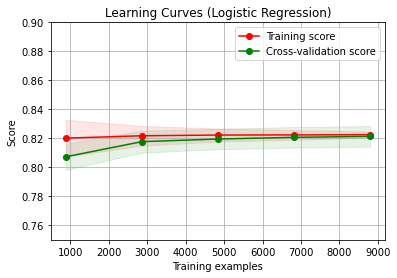

In [16]:

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()

# Plot Area under the Curve AUC roc_curve auc

In [17]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

# Plot Confusion Matrix plot_confusion_matrix

Esta es una función de visualización de matriz de confusión invocable. Hemos utilizado esta función para visualizar verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos para todos los modelos.

In [18]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [20]:
X_train.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
10735,-0.279732,0.837104,-0.414173,0.895380,-0.166329,-0.689524,0.548928,1.563513,0.443667,-0.668192,0.097569,1.083275,-0.872927,0.617987,-0.472259,-0.239805,-1.524476
5937,-1.068606,-1.510863,-0.451323,0.895380,0.602627,-0.704200,-0.843711,-0.323586,-0.197717,-0.065375,-0.244523,-0.152027,-0.177104,-0.119505,-0.439284,-0.697630,0.281629
7642,1.298017,-0.336879,-0.246998,0.895380,-0.166329,-0.666076,0.084715,-0.323586,0.331824,0.537442,0.097569,-0.607138,0.108070,0.863817,-0.600883,-0.033726,1.365292
3328,0.533416,0.837104,-0.098398,-2.167418,-1.704242,-0.620630,-0.843711,1.563513,1.893058,-1.070070,-1.270798,-0.347074,-1.466088,-2.508670,-0.599893,-0.564542,1.004071
8681,1.176652,1.130600,2.724998,-0.636019,-0.166329,0.590513,-0.843711,-0.323586,0.667352,-0.065375,-0.586615,0.823211,0.404651,-1.805748,1.228255,0.733571,-1.524476


Selección de características mediante RFE (eliminación de características recursivas)

In [21]:
from sklearn.feature_selection import RFE
# crea el modelo RFE y selecciona 3 atributos
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# resumir la selección de los atributos
print(rfe.support_)
print(rfe.ranking_)
# ['funded_amnt','emp_length','annual_inc','home_ownership','grade',"last_pymnt_amnt", "mort_acc", "pub_rec", 
# "int_rate", "open_acc","num_actv_rev_tl","mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
#"avg_cur_bal","acc_open_past_24mths",'loan_status']

[ True  True  True False  True  True False False  True False False  True
 False  True  True False  True]
[1 1 1 7 1 1 6 2 1 3 5 1 4 1 1 8 1]


In [22]:
#PCA (Principal Component Analysis) (Análisis de componentes principales)
from sklearn.decomposition import PCA 
pca = PCA(n_components=10, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.1614678  0.15794713 0.12530236 0.07521996 0.07122923 0.06708648
 0.05721979 0.04853042 0.04317424 0.03747952]


In [23]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8800, 10)
(11000, 11)


# Plot Correlation Coefficient

<AxesSubplot:>

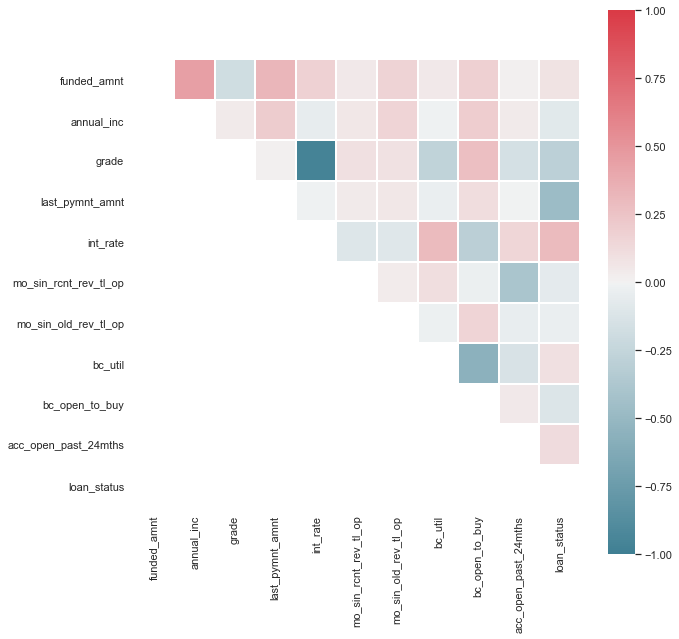

In [24]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Genera una máscara para el triángulo superior.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Genere un mapa de colores divergentes personalizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

# SVM

[ 1. -1. -1. ... -1.  1.  1.]
0.8230000000000006


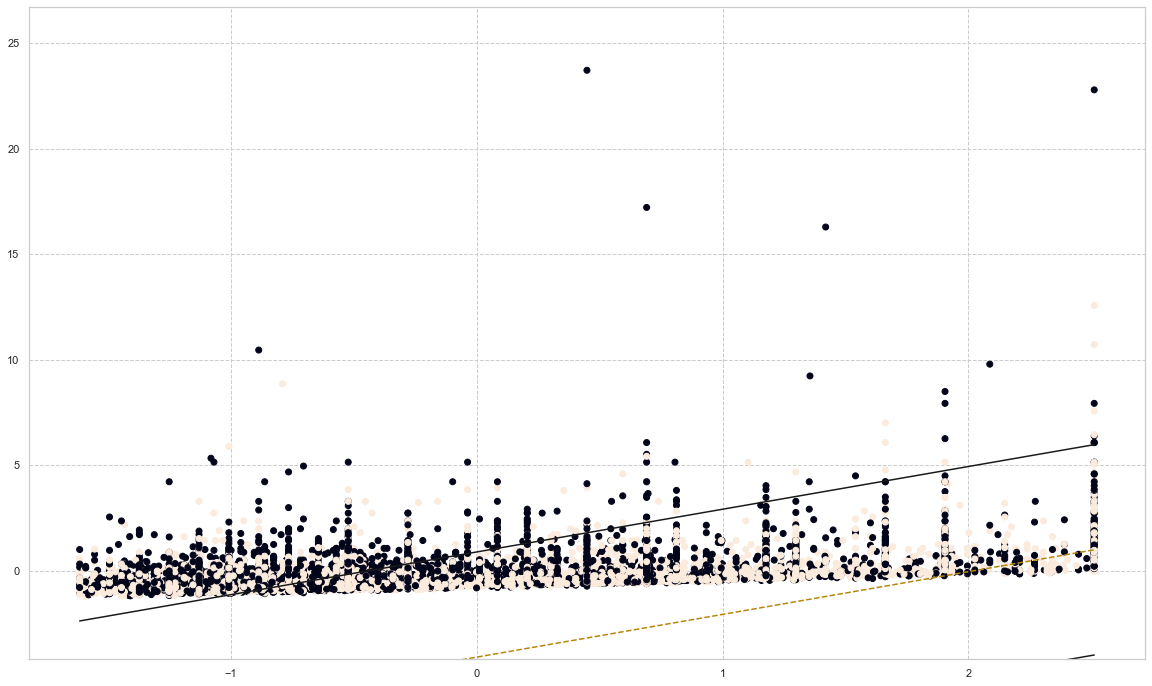

In [28]:
import numpy as np


class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)


# Testing
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    #y = np.where(y == 0, -1, 1)

    clf = SVM()
    clf.fit(X, y)
    predictions = clf.predict(X)
    print(predictions)
    print(clf.b)

    def visualize_svm():
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])

        x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
        x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

        x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
        x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

        x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
        x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])
        plt.rcParams["figure.figsize"] = (20, 12)
        plt.show()

    visualize_svm()

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Use Matplotlib in jupyter
%matplotlib inline

X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values


#Random Forest with randomized Search

El Random forest cuando se implementó con randomized search obtuvimos las mejores precisiones y un mínimo de falsos negativos (la predicción de borowwer no fallará aunque lo haga. Esto podría afectar la credibilidad de la empresa). Usamos la randomized search para encontrar los mejores hiperparámetros para el modelo.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
                   n_iter=9, param_distributions={'max_features': range(1, 10)},
                   random_state=10, scoring='accuracy')

In [26]:
print(rand.best_estimator_)

RandomForestClassifier(max_features=5, random_state=0)


In [27]:
rand.cv_results_.values()

dict_values([array([0.57884364, 0.82260234, 1.09089575, 1.36890426, 1.65380499,
       1.93576858, 2.19753652, 3.050527  , 3.11201079]), array([0.00885953, 0.00427831, 0.01060575, 0.01270558, 0.02122401,
       0.01778606, 0.02858822, 0.38762287, 0.16974242]), array([0.02264409, 0.02037134, 0.01914744, 0.01935422, 0.0189698 ,
       0.01877003, 0.01837401, 0.02294509, 0.02065151]), array([0.00327736, 0.00119866, 0.00040664, 0.0015565 , 0.00154538,
       0.00183064, 0.00195834, 0.00291853, 0.00166724]), masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), [{'max_features': 1}, {'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}, {'max_features': 6}, {'max_features': 7}, {'max_features': 8}, {'max_features': 9}], array([0.82272727, 0.82545455, 0.82181818, 0.81545455, 0.82727273,
       0.82272727, 0.81909091, 0.8

In [28]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.8236363636363636


#Importancia de la característica

Text(0, 0.5, 'Normalized Gini Importance')

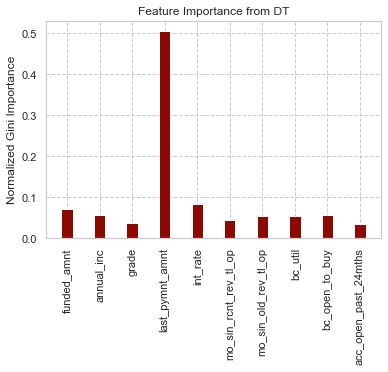

In [29]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

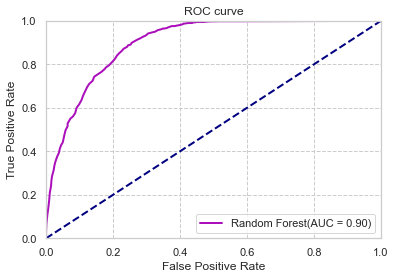

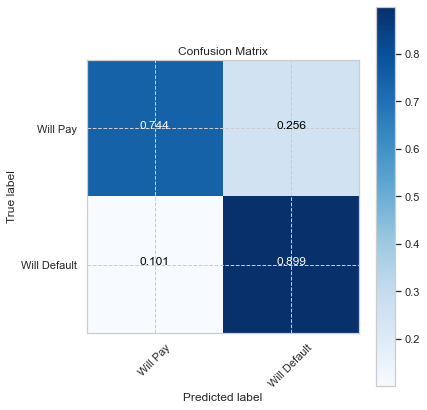

In [30]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

In [31]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = [result for result in grid.cv_results_]
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

Best accuracy is 0.8178181818181818
LogisticRegression(C=10, random_state=0)


Logistic regression accuracy is  0.8036363636363636


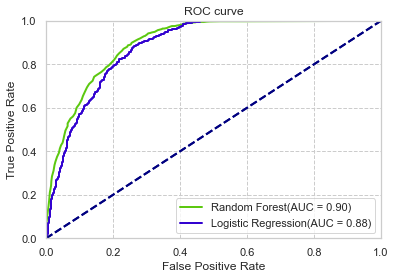

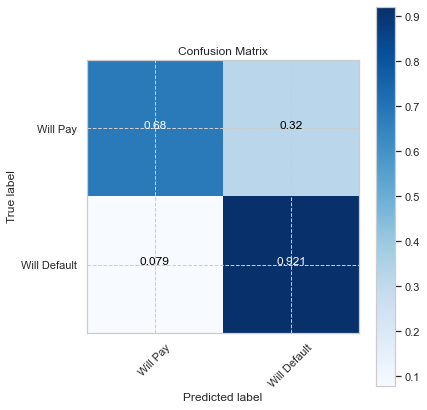

In [32]:
clf_LR = linear_model.LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

#SVM

In [33]:
from sklearn.model_selection import GridSearchCV   ## takes too much time to run this cell.
clf_svm = svm.SVC()
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = dict(C=cs)
grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
grid_mean_scores = [result for result in grid.cv_results_]# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'C': 10}
---------------
SVC(C=10)


SVM accuracy is  0.7977272727272727


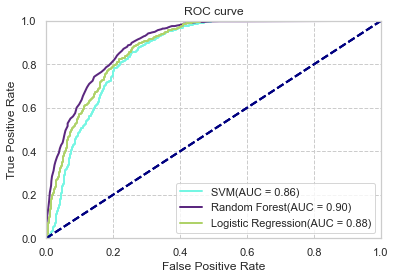

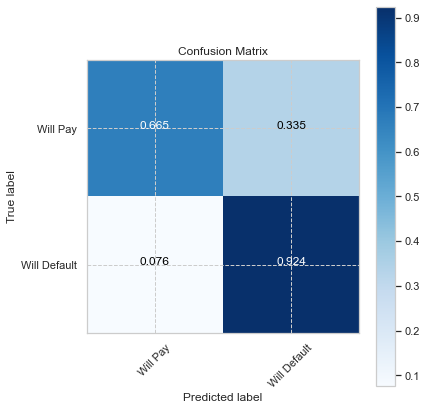

In [34]:
clf_svm = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf_svm.fit(X_train.iloc[:,:],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,:])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,:])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

#KNN

In [35]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
grid_mean_scores = [result for result in grid.cv_results_]# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 46}
---------------
KNeighborsClassifier(n_neighbors=46)


 46
KNN accuracy is  0.7613636363636364


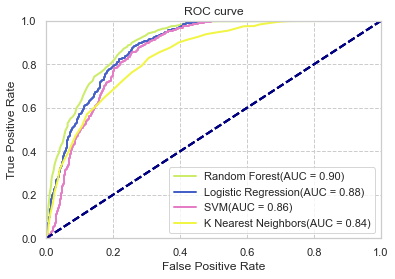

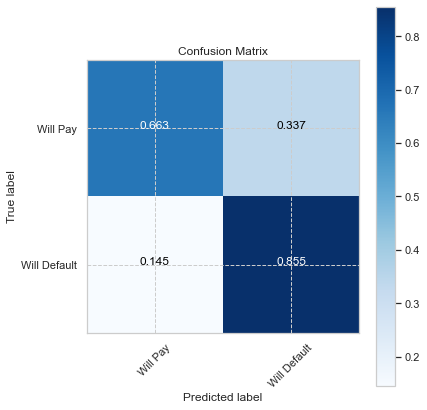

In [36]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

# Bagging, Model Evaluation, KFold, Ensemble

In [37]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

0.8291818181818182


In [38]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
#num_trees = 100 por defecto ->10
model = BaggingClassifier(base_estimator=clf_LR, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

0.8186363636363637


In [39]:
modelBagging = model.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)

In [40]:
 y_predBagging=modelBagging.predict(X_test)

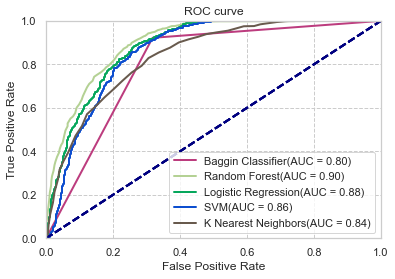

In [41]:
plotAUC(y_test,y_predBagging, 'Baggin Classifier')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()

#Ada Boost classifier

Ada Boost es uno de los algoritmos de conjunto más utilizados.
Funciona ponderando las instancias en el conjunto de datos según su facilidad o dificultad para clasificar, lo que permite que el algoritmo les preste o menos atención en la construcción de modelos posteriores.

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
scores.mean()

0.828

In [43]:
modelAda = Ada_clf.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)

In [44]:
y_predAda = modelAda.predict(X_test)

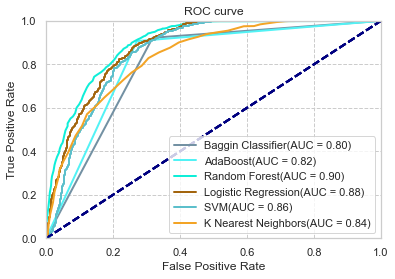

In [45]:
plotAUC(y_test,y_predBagging, 'Baggin Classifier')
plotAUC(y_test,y_predAda, 'AdaBoost')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()

#xgBoost classifier

In [46]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[11:43:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 80.95%


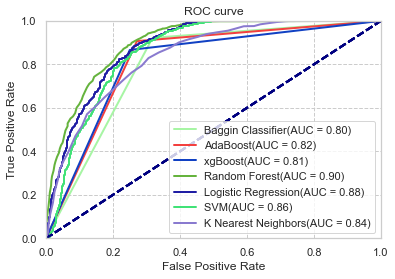

In [47]:
plotAUC(y_test,y_predBagging, 'Baggin Classifier')
plotAUC(y_test,y_predAda, 'AdaBoost')
plotAUC(y_test,y_pred, 'xgBoost')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()

# Neural Network, MLPClassifier

0.8086363636363636


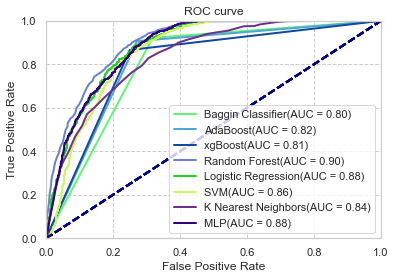

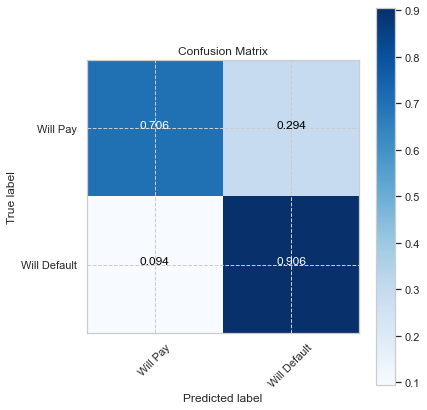

In [48]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,y_predBagging, 'Baggin Classifier')
plotAUC(y_test,y_predAda, 'AdaBoost')
plotAUC(y_test,y_pred, 'xgBoost')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

# Generate Classification Report

In [49]:
from sklearn.metrics import classification_report
print("Baggin",classification_report(y_test, y_predBagging, target_names=None))
print("AdaBoost",classification_report(y_test, y_predAda, target_names=None))
print("xgBoost",classification_report(y_test, y_pred, target_names=None))
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("MLP",classification_report(y_test, predict_NN, target_names=None))

Baggin               precision    recall  f1-score   support

           0       0.89      0.68      0.77      1072
           1       0.75      0.92      0.83      1128

    accuracy                           0.81      2200
   macro avg       0.82      0.80      0.80      2200
weighted avg       0.82      0.81      0.80      2200

AdaBoost               precision    recall  f1-score   support

           0       0.88      0.73      0.80      1072
           1       0.78      0.91      0.84      1128

    accuracy                           0.82      2200
   macro avg       0.83      0.82      0.82      2200
weighted avg       0.83      0.82      0.82      2200

xgBoost               precision    recall  f1-score   support

           0       0.84      0.75      0.79      1072
           1       0.78      0.87      0.82      1128

    accuracy                           0.81      2200
   macro avg       0.81      0.81      0.81      2200
weighted avg       0.81      0.81      0.81      2

# Comportamiento de modelos con diferentes tamaños de muestra de dataset

Aquí hemos trazado Curvas Roc para diferentes tamaños de muestra similares a lo que hemos hecho con los casos anteriores.

In [50]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c) 
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target,1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target,1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]
            
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [51]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000] #various samples of Dataset
LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 20, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 20, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    print(n)

250
1000
1500
2000
2750
3750
4500
5200
6500
7000
8000
8500
9000
10000
11000


# Plot Logarithmic Curve, ROC AUC Score

Text(0, 0.5, 'roc_auc_score')

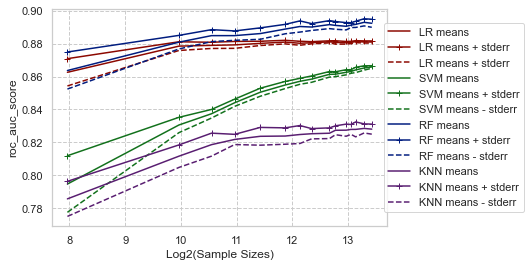

In [52]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-', label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(bbox_to_anchor=(1.20, 0.5),loc = 10)
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

# Logist Regression algoritmo

0.89

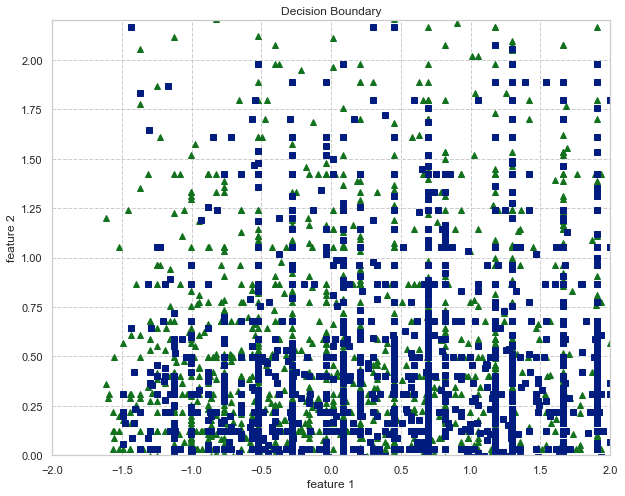

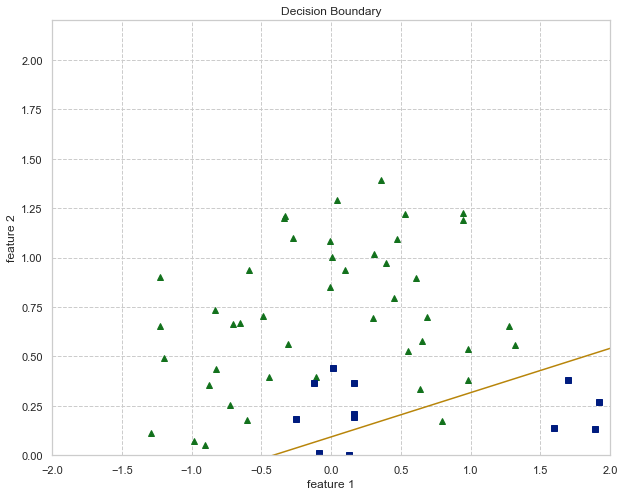

In [53]:
#La función sigmoide aplasta todas sus entradas (valores en el eje x) entre 0 y 1,

#Podemos ver que a medida que z aumenta hacia el infinito positivo, 
#la salida se acerca a 1, y cuando z disminuye hacia el infinito negativo, la salida se acerca a 0.
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

#Para cada algoritmo de aprendizaje automático paramétrico, necesitamos una función de pérdida, 
#que queremos minimizar (encontrar el mínimo global de) para determinar los parámetros óptimos 
#(w y b) que nos ayudarán a hacer las mejores predicciones.
def loss(y, y_hat):
    loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
    return loss

def gradients(X, y, y_hat):
    m = X.shape[0]
    dw = (1/m)*np.dot(X.T, (y_hat - y))
    db = (1/m)*np.sum((y_hat - y)) 
    return dw, db

def plot_decision_boundary(X, w, b):
    
    x1 = [min(X[:,0]), max(X[:,0])]
    m = -w[0]/w[1]
    c = -b/w[1]
    x2 = m*x1 + c
    
    # Plotting
    fig = plt.figure(figsize=(10,8))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.xlim([-2, 2])
    plt.ylim([0, 2.2])
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title('Decision Boundary')
    plt.plot(x1, x2, 'y-')
    
def normalize(X):
    m, n = X.shape
    for i in range(n):
        X = (X - X.mean(axis=0))/X.std(axis=0)
    return X

def train(X, y, bs, epochs, lr):
    
    m, n = X.shape
    w = np.zeros((n,1))
    b = 0
    
    y = y.reshape(m,1)
    
    x = normalize(X)
    
    losses = []
    
    # Training loop.
    for epoch in range(epochs):
        for i in range((m-1)//bs + 1):
            
            start_i = i*bs
            end_i = start_i + bs
            xb = X[start_i:end_i]
            yb = y[start_i:end_i]
            
            y_hat = sigmoid(np.dot(xb, w) + b)
            
            dw, db = gradients(xb, yb, y_hat)
            
            w -= lr*dw
            b -= lr*db
        
        l = loss(y, sigmoid(np.dot(X, w) + b))
        losses.append(l)
        
    return w, b, losses

def predict(X):
    x = normalize(X)
    
    preds = sigmoid(np.dot(X, w) + b)
    
    pred_class = []    
    pred_class = [1 if i > 0.5 else 0 for i in preds]
    
    return np.array(pred_class)

# Training 
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
w, b, l = train(X, y, bs=100, epochs=80000, lr=0.01)
plot_decision_boundary(X, w, b)

def accuracy(y, y_hat):
    accuracy = np.sum(y == y_hat) / len(y)
    return accuracy

accuracy(X, y_hat=predict(X))
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.24)

# Training 
w, b, l = train(X, y, bs=100, epochs=80000, lr=0.01)
plot_decision_boundary(X, w, b)

accuracy(y, predict(X))

# KNN Algoritmo

In [59]:
#Importing the required modules
import numpy as np
from scipy.stats import mode
 
#Distancia euclidiana
def eucledian(p1,p2):
    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist
 
#Función para calcular KNN
def predict(x_train, y , x_input, k):
    op_labels = []
     
    #Recorra los puntos de datos que se van a clasificar
    for item in x_input: 
         
        #Arrelgo para almacenar distancias
        point_dist = []
         
        #Recorre cada uno de los datos de entrenamiento
        for j in range(len(x_train)): 
            distances = eucledian(np.array(x_train[j,:]) , item) 
            #Calcular la distancia
            point_dist.append(distances) 
        point_dist = np.array(point_dist) 
         
        #Ordenar la matriz conservando el índice
        #Mantener los primeros K puntos de datos
        dist = np.argsort(point_dist)[:k] 
         
        #Etiquetas de los puntos de datos K desde arriba
        labels = y[dist]
         
        #Votación mayoritaria
        lab = mode(labels) 
        lab = lab.mode[0]
        op_labels.append(lab)
 
    return op_labels

In [67]:
#Importando los módulos requeridos
from sklearn.metrics import accuracy_score
from numpy.random import randint
 
#Data
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
 
#Creando los datos de entrenamiento
train_idx = xxx = randint(0,11000,7000)
X_train = X[train_idx]
y_train = y[train_idx]
 
#Crear los datos de prueba
test_idx = xxx = randint(0,11000,7000) #tomando 7000 muestras aleatorias
X_test = X[test_idx]
y_test = y[test_idx]
 
#Aplicando nuestra función
y_pred = predict(X_train,y_train,X_test , 7)
 
#Comprobando la precisión
accuracy_score(y_test, y_pred)

0.7665714285714286